# 1 Introduction

In this NoteBook, I will conduct exploratory data analysis (EDA) and clean the EdNet dataset by handling null values, parsing timestamps and eliminating duplicate records to ensure data integrity. Following this, I will perform comprehensive data processing and mining to extract meaningful patterns. A crucial step involves constructing a user-content interaction matrix, which will facilitate insightful analysis of engagement. The preprocessed data will be systematically saved in the `/data/cleaned/` directory for use.
## 1.2 Importing the required libraries

I will start by loading the required libraries

In [1]:
# Importing necessary libraries for data manipulation & visualization
import numpy as np # Is used for numerical operations and handling arrays
import pandas as pd # Is used for handling structured data in DataFrames
import matplotlib.pyplot as plt # Is used for creating static visualizations
import seaborn as sns # Provides statistical data visualization capabilities built on top of Matplotlib
import os # Helps with file & directory operations
from collections import Counter # Is useful for counting occurrences of elements in a dataset

sns.set(style="whitegrid") # Sets the style of seaborn plots to have a white grid background

# 2 Implementation
## 2.1 Loading the datasets

I will load the chosen datasets here. The datasets I have chosen from EdNet are **EdNet-KT1** for user interaction & performance logs, **Contents' questions.csv** for metadata used in content-based filtering and **Contents' lectures.csv** as a supplement for richer recommendations.

**EdNet-KT1** is very large, with over **784,309** files. I couldn't include and use all the files, so I wrote a script named `ednet_kt1_sampler.py` to curate this dataset. Here’s how it works: The provided code defines a function, `sample_kt1_logs`, which randomly selects and combines files from the EdNet-KT1 dataset directory into a single DataFrame. It first identifies CSV files following the naming convention (`u*.csv`), then randomly samples a specified number of user logs. Each sampled log is read into a DataFrame, with the user ID extracted from the filename and added as a column. The data is then merged into a single DataFrame and returned. Finally, the script calls this function with a sample size of 1000, saves the resulting dataset as `sampled_kt1_logs.csv`, ensuring a structured subset for further analysis. This code can be found in `../data/`.

In [2]:
# Load datasets from ../data/
sampled_logs = pd.read_csv("../data/sampled_kt1_logs.csv")
questions = pd.read_csv("../data/questions.csv")
lectures = pd.read_csv("../data/lectures.csv") 

# Define output directory for cleaned data
output_dir = "../data/cleaned" # Directory & path to save cleaned data
os.makedirs(output_dir, exist_ok=True) # Create directory if it doesn't already exist

The datasets are loaded successfully and I have set up a directory to store the cleaned data.

## 2.2 Data Exploration & Cleaning

Next, I will inspect the datasets to understand its structure, identify any issues with missing values, duplicates and extreme values, and get a sense of the overall data distribution. Then I clean the datasets if needed and save it in the **../data/cleaned** directory I have set up before.

### 1. Sampled KT1 Logs 

#### Preview the Data

In [3]:
# Inspect Sampled KT1 Logs
sampled_logs.head() # Display the first few rows

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id
0,1521971827112,1,q8098,b,12000,u145242
1,1521971855061,2,q8074,d,25000,u145242
2,1521971879724,3,q176,b,22000,u145242
3,1521971899710,4,q1279,c,17000,u145242
4,1521971943593,5,q2067,a,13333,u145242


The initial preview of the data provides us with columns such as timestamp, solving_id, question_id, user_answer, elapsed_time and	user_id. This will help us understand the format and context of the data.

#### General Information

Here I used the info() function that provides an overview of the dataset. This is useful for understanding the overall structure of the data and whether there are any columns with missing or incorrectly formatted data that I need to address.

In [4]:
print("\n=== KT1 Info ===")
sampled_logs.info() # Show basic information


=== KT1 Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117512 entries, 0 to 117511
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     117512 non-null  int64 
 1   solving_id    117512 non-null  int64 
 2   question_id   117512 non-null  object
 3   user_answer   117502 non-null  object
 4   elapsed_time  117512 non-null  int64 
 5   user_id       117512 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.4+ MB


The above DataFrame contains **117,512 rows and 6 columns**, storing data on user interactions with questions. It tracks each attempt with a `timestamp`, `solving_id`, and `question_id`, while also recording users' answers (`user_answer`), their response time (`elapsed_time`), and unique identifiers (`user_id`). Most columns have complete data, except `user_answer`, which has **10 missing entries**. This also shows that `question_id is object`, needs conversion and `timestamp` is Unix-style int64, needs datetime parsing.

#### Statistical Summary

 The describe() function gives us a statistical summary of the numerical columns in the dataset. This summary helps me identify any potential issues, such as outliers or skewed distributions, that I may need to address.

In [5]:
print("\n=== KT1 Description ===")
sampled_logs.describe() # Show descriptive statistics


=== KT1 Description ===


,timestamp,solving_id,elapsed_time
count,1.175120e+05,117512.000000,1.175120e+05
mean,1.542604e+12,995.423829,2.492519e+04
std,2.104613e+10,1481.194482,2.844269e+04
min,1.492530e+12,1.000000,0.000000e+00
25%,1.526855e+12,79.000000,1.600000e+04
50%,1.548086e+12,360.000000,2.100000e+04
75%,1.561172e+12,1169.000000,2.900000e+04
max,1.575304e+12,6949.000000,5.468000e+06


In the above output, `timestamp` shows the range of timestamps in milliseconds, with a mean of 1.5426e+12 and a large standard deviation indicating wide variation in the times. solving_id `ranges` from 1 to 6949, with most entries being concentrated below 1000 `elapsed_time` has a large spread, with values ranging from 0 to 5.46 million ms, which may indicate some outliers in the time taken for solving questions.

#### Missing Values Check

Even tough missing values are already checked in **General Information**. I will check again properly just to make sure

In [6]:
print("\n=== KT1 Missing Values ===")
sampled_logs.isna().sum() # Count the number of missing values in each column


=== KT1 Missing Values ===


timestamp        0
solving_id       0
question_id      0
user_answer     10
elapsed_time     0
user_id          0
dtype: int64

It confirms that there are 10 missing values in the user_answer column.

#### Checking for Duplicates

Here I will  check for duplicate rows in the dataset by using duplicated() function which detects duplicates and sum() counts how many duplicate rows exist in the DataFrame.

In [7]:
print("\n=== KT1 Duplicates ===")
duplicate_rows = sampled_logs.duplicated().sum()  # Count how many rows are duplicates
print(f"Number of duplicate rows: {duplicate_rows}")


=== KT1 Duplicates ===
Number of duplicate rows: 0


The output above confirm that there are no duplicate rows in the sampled_logs

#### Cleaning the Data

Here I will drop rows with missing `user_answer` values using dropna(). Convert the `timestamp` column from Unix time (milliseconds) to a human-readable datetime format. This makes it easier to work with and analyze time-based data. Ensure data consistency by explicitly converting columns to the appropriate data types (str for `question_id`, `user_id` and `user_answer`), this is important for consistency, especially for operations like grouping, filtering, or merging datasets.

In [8]:
# Drop rows where user_answer is null (incomplete responses)
sampled_logs = sampled_logs.dropna(subset=["user_answer"])

# Convert timestamp from milliseconds to datetime format
sampled_logs["timestamp"] = pd.to_datetime(sampled_logs["timestamp"], unit='ms')

# Ensure the correct (strings) types for certain columns to avoid errors during processing
sampled_logs["question_id"] = sampled_logs["question_id"].astype(str)
sampled_logs["user_id"] = sampled_logs["user_id"].astype(str)
sampled_logs["user_answer"] = sampled_logs["user_answer"].fillna('').astype(str)  # Replace NaNs with an empty string before converting to str

The below code filters out rows where the `elapsed_time` is either 0 or exceeds 5 minutes (300,000 ms). Extreme values, especially those over 5 minutes, might represent errors or outliers and are excluded from the analysis.

In [9]:
# Filter out records where elapsed_time is either zero or greater than 5 minutes
sampled_logs = sampled_logs[
    (sampled_logs["elapsed_time"] > 0) & 
    (sampled_logs["elapsed_time"] <= 300000)
]

#### Checking the data after cleaning

##### timestamp

In [10]:
sampled_logs.head()  # Display the first few rows of the cleaned sampled_logs DataFrame

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id
0,2018-03-25 09:57:07.112,1,q8098,b,12000,u145242
1,2018-03-25 09:57:35.061,2,q8074,d,25000,u145242
2,2018-03-25 09:57:59.724,3,q176,b,22000,u145242
3,2018-03-25 09:58:19.710,4,q1279,c,17000,u145242
4,2018-03-25 09:59:03.593,5,q2067,a,13333,u145242


Now  `timestamp` looks human readable and the format is correct. It’s now in a proper datetime format, which shows both the date and time with millisecond precision (e.g., `2018-03-25 09:57:07.112`).

Now I will **check the range of dates** by making sure the timestamps cover the expected period and are not too far in the future or too far in the past.

In [11]:
sampled_logs['timestamp'].min(), sampled_logs['timestamp'].max()  # Check the range of dates

(Timestamp('2017-04-18 15:44:40.218000'),
 Timestamp('2019-12-02 16:30:10.437000'))

This range seems perfectly reasonable. **The start date** (`2017-04-18`) and **end date** (`2019-12-02`) span over more than two years. This is a typical range for data collected over a long period, like logs for user interactions, exam responses or learning system activities. The timestamps also include **millisecond precision** (e.g., `15:44:40.218000`), indicating that the data collection is quite detailed, which is consistent with the way I converted the `timestamp` column from milliseconds to datetime.

##### Checking Null values & Data types

In [12]:
print("\n=== KT1 Info ===")
sampled_logs.info() # Show basic information


=== KT1 Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 117167 entries, 0 to 117511
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   timestamp     117167 non-null  datetime64[ns]
 1   solving_id    117167 non-null  int64         
 2   question_id   117167 non-null  object        
 3   user_answer   117167 non-null  object        
 4   elapsed_time  117167 non-null  int64         
 5   user_id       117167 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 6.3+ MB


The key differences between the dataset **before** and **after** the transformation are as follows:

**`timestamp` Column:**

- **Before**: The `timestamp` column had the type `int64`, indicating that it was likely stored as raw milliseconds or Unix timestamps.
- **After**: The `timestamp` column is now correctly converted to `datetime64[ns]`, which is the expected format for handling dates and times in pandas. This means I have successfully converted the raw timestamp values to actual datetime objects.

**`user_answer` Column:**

- **Before**: The `user_answer` column had **10 missing values**
- **After**: The missing values in the `user_answer` column have been **dropped**

**Memory Usage:**

- **Before**: The memory usage was **5.4 MB**, which is expected for a dataset of this size.
- **After**: The memory usage increased slightly to **6.3 MB**, likely because of the conversion of the `timestamp` column from an integer (which uses less memory) to a `datetime64` format (which takes up more space).

### 2. Questions

Now the same process as ***1.Sampled KT1 Logs*** is repeated for ***2. Questions***.

#### Preview the Data

In [13]:
# Inspect Questions
print("=== Questions Preview ===")
display(questions.head())

=== Questions Preview ===


,question_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,q1,b1,e1,b,1,1;2;179;181,1558093217098
1,q2,b2,e2,a,1,15;2;182,1558093219720
2,q3,b3,e3,b,1,14;2;179;183,1558093222784
3,q4,b4,e4,b,1,9;2;179;184,1558093225357
4,q5,b5,e5,c,1,8;2;179;181,1558093228439


The above preview shows the following key columns:
- **question_id:** A unique identifier for each question.
- **bundle_id:** The associated bundle to which the question belongs.
- **explanation_id:** Links to an explanation of the question.
- **correct_answer:** The correct answer for the question.
- **part:** The section or part to which the question belongs (e.g., part of a larger exam or module).
- **tags:** Associated tags for the question, which might represent topics or categories.
- **deployed_at:** The timestamp when the question was deployed (Unix timestamp in milliseconds).

#### General Information

In [14]:
print("\n=== Questions Info ===")
questions.info()


=== Questions Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13169 non-null  object
 1   bundle_id       13169 non-null  object
 2   explanation_id  13169 non-null  object
 3   correct_answer  13169 non-null  object
 4   part            13169 non-null  int64 
 5   tags            13169 non-null  object
 6   deployed_at     13169 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 720.3+ KB


In the above output, the `questions` DataFrame contains **13,169 entries** (rows). There are 7 columns: `question_id`, `bundle_id`, `explanation_id`, `correct_answer`, `part`, `tags` and `deployed_at`. The `part` and `deployed_at` columns have numeric data types (`int64`), while the other columns (`question_id`, `bundle_id`, etc.) are of type `object` (strings). There are no missing (null) values in any of the columns, as indicated by the "non-null" count matching the total number of rows.

#### Statistical Summary

In [15]:
print("\n=== Questions Description ===")
display(questions.describe(include='all'))


=== Questions Description ===


,question_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
count,13169,13169,13169,13169,13169.000000,13169,1.316900e+04
unique,13169,9534,9534,4,NaN,1792,NaN
top,q18143,b5709,e5709,b,NaN,-1,NaN
freq,1,5,5,3624,NaN,797,NaN
mean,NaN,NaN,NaN,NaN,4.460172,NaN,1.304772e+12
std,NaN,NaN,NaN,NaN,1.620358,NaN,5.688381e+11
min,NaN,NaN,NaN,NaN,1.000000,NaN,-1.000000e+00
25%,NaN,NaN,NaN,NaN,3.000000,NaN,1.514962e+12
50%,NaN,NaN,NaN,NaN,5.000000,NaN,1.558093e+12
75%,NaN,NaN,NaN,NaN,5.000000,NaN,1.568688e+12


The above output shows the following:
- **question_id:** Every question has a unique ID.
- **bundle_id & explanation_id:** There are 9,534 unique bundles and explanations, but the most frequent bundle and explanation appear 5 times.
- **correct_answer:** The `correct_answer` column has 4 unique values (likely "a", "b", "c", "d"), with answer "b" being the most frequent (3,624 times).
- **part:** The part column has values between 1 and 7, with part 5 being the most common.
- **tags:** There are 1,792 unique tags associated with the questions.
- **deployed_at:** The `deployed_at` column is a Unix timestamp. The summary statistics show the range of deployment times, with a minimum timestamp of `-1`, indicating a possible erroneous or special value that needs to be fixed.

#### Missing Values Check

In [16]:
print("\n=== Questions Missing Values ===")
print(questions.isna().sum())


=== Questions Missing Values ===
question_id       0
bundle_id         0
explanation_id    0
correct_answer    0
part              0
tags              0
deployed_at       0
dtype: int64


#### Checking for Duplicates

In [17]:
print("\n=== Questions Duplicates ===")
duplicate_rows = questions.duplicated().sum() # Count how many rows are duplicates
print(f"Number of duplicate rows: {duplicate_rows}")


=== Questions Duplicates ===
Number of duplicate rows: 0


As seen above, there are no missing and duplicated values.

#### Cleaning the Data

This code below removes any duplicate rows and rows with missing (NaN) values (although no rows were found to be missing, this step ensures data integrity). And **Convert `deployed_at` to datetime**: The `deployed_at` column is a Unix timestamp in milliseconds, which is converted into a human-readable `datetime` format using the `pd.to_datetime()` method.

In [18]:
# Clean Questions
questions = questions.drop_duplicates()
questions = questions.dropna()
# Convert deployed_at from milliseconds to datetime format
questions['deployed_at'] = pd.to_datetime(questions['deployed_at'], unit='ms')

#### Checking the data after cleaning

##### deployed_at

In [19]:
display(questions.head())

,question_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,q1,b1,e1,b,1,1;2;179;181,2019-05-17 11:40:17.098
1,q2,b2,e2,a,1,15;2;182,2019-05-17 11:40:19.720
2,q3,b3,e3,b,1,14;2;179;183,2019-05-17 11:40:22.784
3,q4,b4,e4,b,1,9;2;179;184,2019-05-17 11:40:25.357
4,q5,b5,e5,c,1,8;2;179;181,2019-05-17 11:40:28.439


The `deployed_at` column is now in a `datetime` format, making it easier to analyze the deployment times.

### 3. Lectures

Again, the same process as ***1.Sampled KT1 Logs*** and ***2. Questions*** is repeated for ***3. Lectures***.

#### Preview the Data

In [20]:
# Inspect Lectures
print("=== Lectures Preview ===")
display(lectures.head())

=== Lectures Preview ===


,lecture_id,part,tags,video_length,deployed_at
0,l520,5,142,-1,-1
1,l592,6,142,-1,-1
2,l1259,1,222,359000,1570424729123
3,l1260,1,220,487000,1570424738105
4,l1261,1,221,441000,1570424743162


The above output shows the following:
- **lecture_id:** A unique identifier for each lecture.
- **part:** The part or section of the lecture (e.g., part of a series).
- **tags:** Numeric tags, possibly referring to the categories or topics of the lecture.
- **video_length:** The length of the lecture video in milliseconds. The value `-1` could indicate missing or unavailable video length.
- **deployed_at:** The Unix timestamp in milliseconds indicating when the lecture was deployed. Values of `-1` could indicate missing deployment times.

#### General Information

In [21]:
print("\n=== Lectures Info ===")
lectures.info()


=== Lectures Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lecture_id    1021 non-null   object
 1   part          1021 non-null   int64 
 2   tags          1021 non-null   int64 
 3   video_length  1021 non-null   int64 
 4   deployed_at   1021 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 40.0+ KB


In the above output, the `lectures` DataFrame contains **1,021 entries** (rows) and **5 columns**: `lecture_id`, `part`, `tags`, `video_length`, and `deployed_at`. All columns except `lecture_id` are of type `int64`, indicating that the data is numeric in nature, with `lecture_id` being of type `object` (string). The DataFrame has **no missing values** in any of the columns, as each column contains 1,021 non-null values.

#### Statistical Summary

In [22]:
print("\n=== Lectures Description ===")
display(lectures.describe(include='all'))


=== Lectures Description ===


,lecture_id,part,tags,video_length,deployed_at
count,1021,1021.000000,1021.000000,1.021000e+03,1.021000e+03
unique,1021,NaN,NaN,NaN,NaN
top,l843,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,1.842311,69.219393,1.472973e+05,8.735165e+11
std,NaN,2.908340,83.938264,1.830251e+05,7.804772e+11
min,NaN,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00
25%,NaN,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00
50%,NaN,1.000000,33.000000,1.220000e+05,1.570425e+12
75%,NaN,5.000000,120.000000,2.320000e+05,1.570426e+12


The above output shows the following:
- **lecture_id:** Every lecture has a unique `lecture_id`.
- **part:** The `part` column shows that the lectures are spread across various parts, with the values ranging from `-1` to `7`.
- **tags:** The `tags` column is numeric, with values ranging from `-1` to `298`. The `-1` values could represent missing or invalid tags.
- **video_length:** The video length ranges from `-1` to `1,042,000` ms, with a mean of approximately 147,297 ms (around 2.45 minutes). The presence of `-1` values indicates missing video lengths.
- **deployed_at:** The `deployed_at` column contains Unix timestamps. The values range from `-1` to `1.570427e+12`, with the median deployment time falling around `1.570425e+12` ms.

#### Missing Values Check

In [23]:
print("\n=== Lectures Missing Values ===")
print(lectures.isna().sum())


=== Lectures Missing Values ===
lecture_id      0
part            0
tags            0
video_length    0
deployed_at     0
dtype: int64


#### Checking for Duplicates

In [24]:
print("\n=== Lectures Duplicates ===")
duplicate_rows = lectures.duplicated().sum() # Count how many rows are duplicates
print(f"Number of duplicate rows: {duplicate_rows}")


=== Lectures Duplicates ===
Number of duplicate rows: 0


As seen above, there are no missing and duplicated values.

#### Cleaning the Data

As seen before, the invalid `-1` which indicates null or invalid values are replaced with `NaN` by the code below, making the dataset cleaner for further analysis. And the `deployed_at` column is now in a proper `datetime` format, which is easier to work with for time-based analysis.

In [25]:
# Replace -1 with NaN in specific columns for meaningful missing values
lectures[["part", "tags", "video_length", "deployed_at"]] = lectures[["part", "tags", "video_length", "deployed_at"]].replace(-1, np.nan)

# Convert deployed_at from milliseconds to datetime format, ensuring that invalid values become NaT (Not a Time)
lectures["deployed_at"] = pd.to_datetime(lectures["deployed_at"], unit="ms", errors="coerce")

lectures["video_minutes"] = lectures["video_length"] / 60000 # Convert video length from milliseconds to minutes

#### Checking the data after cleaning

In [26]:
display(lectures.head())

,lecture_id,part,tags,video_length,deployed_at,video_minutes
0,l520,5.0,142.0,NaN,NaT,NaN
1,l592,6.0,142.0,NaN,NaT,NaN
2,l1259,1.0,222.0,359000.0,2019-10-07 05:05:29.123,5.983333
3,l1260,1.0,220.0,487000.0,2019-10-07 05:05:38.105,8.116667
4,l1261,1.0,221.0,441000.0,2019-10-07 05:05:43.162,7.350000


Now all the invalid `-1` are replaced with `NaN` or `NaT` and the `deployed_at` column is now in a proper `datetime` format

## 2.3 Merging sampled_logs.csv and questions.csv 

This code below merges the `sampled_logs.csv` and `questions.csv`. The `index=False` argument ensures that the DataFrame's index is not written to the CSV files.

In [27]:
# Merge sampled logs with questions
merged = pd.merge(sampled_logs, questions, on='question_id', how='inner') # Merge the cleaned sampled logs with the questions DataFrame on question_id

And this code saves the cleaned versions of the `sampled_logs`, `questions` and `merged` DataFrames to CSV files in the specified output directory (`../data/cleaned/`) I made earlier.

In [28]:
# Save cleaned datasets
sampled_logs.to_csv("../data/cleaned/cleaned_sampled_logs.csv", index=False)
questions.to_csv("../data/cleaned/cleaned_questions.csv", index=False)
merged.to_csv("../data/cleaned/merged_cleaned_data.csv", index=False)
lectures.to_csv("../data/cleaned/cleaned_lectures.csv", index=False)

Since lectures are not directly linked to user interactions, I didn't merged it with `sampled_logs`. Instead, I kept `lectures.csv` separately loaded. The reason for this is twofold: first, there is **no direct key to join** lectures with current logs, as `KT1 logs` only contain `question_id` without a corresponding `lecture_id`, meaning there is no user–lecture interaction at this stage. Second, lectures serve as **supplementary content** rather than integral elements of user engagement—unlike questions, lectures are consumed rather than interacted with, so merging them now would not enhance the user-question matrix. Keeping them separate allows for cleaner analysis and preserves their intended role in the dataset.

In [29]:
display(merged.head())

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,2018-03-25 09:57:07.112,1,q8098,b,12000,u145242,b5569,e5569,b,1,5;2;182,2017-12-29 15:06:23.093
1,2018-03-25 09:57:35.061,2,q8074,d,25000,u145242,b5545,e5545,c,1,11;7;183,2018-05-18 08:57:02.552
2,2018-03-25 09:57:59.724,3,q176,b,22000,u145242,b176,e176,d,1,6;7;183,2017-12-29 14:53:43.800
3,2018-03-25 09:58:19.710,4,q1279,c,17000,u145242,b1279,e1279,c,2,24;26;182;184,2019-10-17 02:58:38.714
4,2018-03-25 09:59:03.593,5,q2067,a,13333,u145242,b1623,e1623,b,3,52;183;184,2019-03-12 02:28:10.338


The above is how the merged dataset looks like

## 2.3 Exploratory Data Analysis (EDA)

### 1. Merged data

In [30]:
# Load merged dataset
merged = pd.read_csv("../data/cleaned/merged_cleaned_data.csv")

# Parse timestamps
merged['timestamp'] = pd.to_datetime(merged['timestamp'])
merged['deployed_at'] = pd.to_datetime(merged['deployed_at'])

# Add is_correct column
merged['is_correct'] = merged['user_answer'] == merged['correct_answer']

#### Basic Distributions

In [31]:
print("\n--- Unique Counts ---")
print("Users:", merged['user_id'].nunique())
print("Questions:", merged['question_id'].nunique())


--- Unique Counts ---
Users: 999
Questions: 11345


I first inspect the number of unique users and questions. The dataset above includes 999 students and 11,345 questions, providing a rich base for building personalized and content-based recommendation systems. These counts are especially valuable for assessing dataset scale and recommendation coverage.

In [32]:
print("\n--- Elapsed Time Stats ---")
print(merged['elapsed_time'].describe())


--- Elapsed Time Stats ---
count    117167.000000
mean      24615.522604
std       16763.583629
min         333.000000
25%       16000.000000
50%       21000.000000
75%       29000.000000
max      300000.000000
Name: elapsed_time, dtype: float64


The elapsed time analysis above reveals that on average, students take **\~24.6 seconds** per question. The **75th percentile is \~29 seconds**, while some outliers extend up to **5 minutes** (likely distractions or breaks). These stats are useful for behavioral profiling and could be bucketed into response-speed categories.

In [33]:
print("\n--- Top Tags ---")
tags = merged['tags'].dropna().apply(lambda x: x.split(';'))
all_tags = [tag for sublist in tags for tag in sublist]
tag_counts = Counter(all_tags)
tag_df = pd.DataFrame(tag_counts.items(), columns=["tag", "count"]).sort_values("count", ascending=False)
tag_df.head()


--- Top Tags ---


,tag,count
5,183,23085
58,181,20214
2,182,16273
9,184,15396
16,185,11438


Top recurring tags above include **183**, **181** and **182**, appearing thousands of times. These tags reflect popular or frequently tested concepts, potentially influencing the difficulty distribution and model bias. Understanding tag frequency is essential for curriculum optimization and topic balancing.

In [34]:
# 2. Questions per user
user_counts = merged['user_id'].value_counts()
print("\n=== Questions per user ===")
print(user_counts.describe())


=== Questions per user ===
count      999.000000
mean       117.284284
std        538.588165
min          1.000000
25%          7.000000
50%         12.000000
75%         40.000000
max      10923.000000
Name: count, dtype: float64


The above code measures the number of questions answered per user to analyze participation. This descriptive summary highlights **user activity skewness**.

- **Mean ≠ Median**: High standard deviation (538) and large max value (10,923) suggest heavy right skew, **a few users answered significantly more questions**, indicating potential imbalance.
- I could consider stratified modeling or limiting max per-user interactions during training for fairness.

In [35]:
# 3. Logs per question
question_counts = merged['question_id'].value_counts()
print("\n=== Logs per question ===")
print(question_counts.describe())


=== Logs per question ===
count    11345.000000
mean        10.327633
std         16.716132
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        325.000000
Name: count, dtype: float64


The above code evaluates how often each question appears in the dataset. The output indicates **a few questions are extremely frequent**, while most are rarely seen.

- **Max = 325 attempts vs median = 6**.
- Could bias models toward easier or overused questions.
- I could fix it by sample or weight-loss function by frequency.

In [36]:
# 4. Tag distribution (uses previously defined tag_df)
print("\n=== Top tags by frequency ===")
tag_df.head(10)


=== Top tags by frequency ===


,tag,count
5,183,23085
58,181,20214
2,182,16273
9,184,15396
16,185,11438
12,179,10770
7,24,9867
10,52,6024
1,2,4798
68,30,4458


The above output shows the most common tags used in questions.
- Some tags are **heavily dominant**, such as tags `183`, `181`, and `182`.
- This affects **tag-based modeling** (e.g., tag difficulty, embeddings) and may result in poor generalization across low-frequency tags.

In basic Distributions 
* I have uncovered **distribution imbalance** in users, questions and tags.
* Not a formal imbalance mitigation yet, but essential for planning fairness-aware modeling or sampling.

#### Correctness & Difficulty

The code below calculates the **average correctness (accuracy rate)** for each question to understand **question difficulty**.
High accuracy → easier question, low accuracy → harder question.

In [37]:
question_accuracy = merged.groupby('question_id')['is_correct'].mean().sort_values()
user_accuracy = merged.groupby('user_id')['is_correct'].mean()

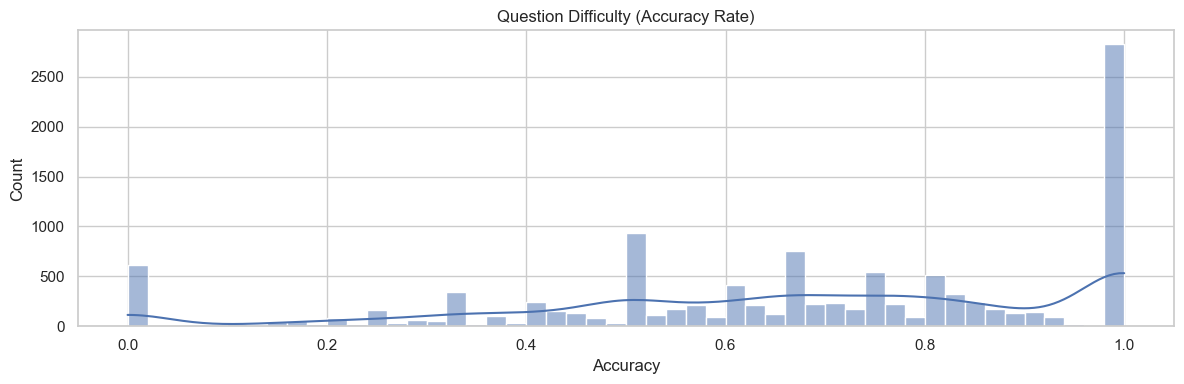

In [38]:
# Plot question difficulty distribution
plt.figure(figsize=(12, 4))
sns.histplot(question_accuracy, bins=50, kde=True)
plt.title("Question Difficulty (Accuracy Rate)")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The plot above visualizes the **distribution of question accuracy rates**, where:

- The **left side (0.0 - 0.2)** shows questions that most users got **wrong** → **hard questions**.
- The **right spike (1.0)** indicates questions that nearly everyone got **correct** → **very easy questions**.
- There's a **bimodal pattern** — many questions cluster at the extremes (0 and 1), with fewer around the mid-range.
- **A tail in the middle** shows a spread of moderately difficult questions.


**- Interpretation:**

- This confirms **imbalance in question difficulty** — most questions are either too hard or too easy.
- For a recommender, I may need to:
  * Balance training samples by difficulty.
  * Include difficulty as a model feature (`tag_difficulty` or `question_accuracy`).

#### Temporal Patterns

This line plot tracks how many questions were answered **per day** over time, revealing **temporal usage patterns** from the EdNet dataset.

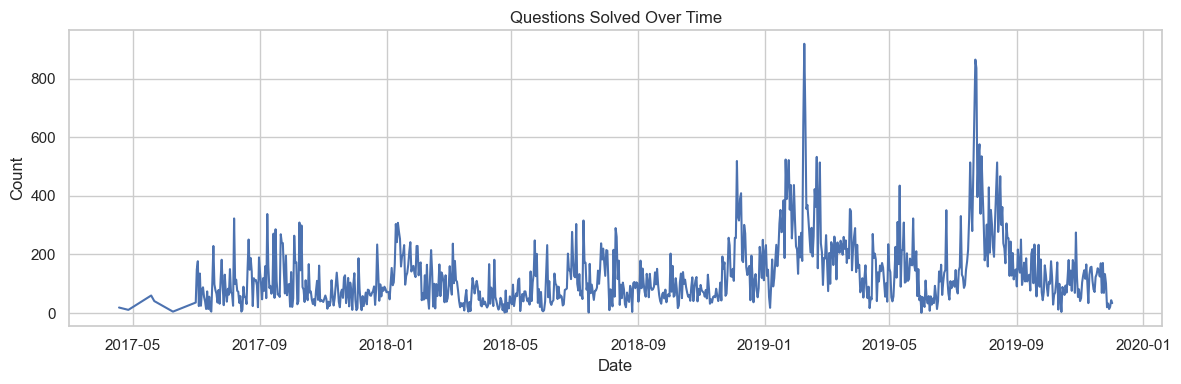

In [39]:
plt.figure(figsize=(12, 4))
merged['timestamp'].dt.date.value_counts().sort_index().plot()
plt.title("Questions Solved Over Time")
plt.ylabel("Count")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

**- Key Insights:**

- Activity began around **mid-2017**, with moderate engagement.
- A significant **increase in activity** is seen from **late 2018 to mid-2019**.
- There are noticeable **spikes**, possibly indicating:

  - Exam seasons or academic deadlines.
  - Campaigns or batch uploads of logs.
- Activity drops slightly by the **end of 2019**, possibly due to academic year-end or dataset coverage limits.

**- Usefulness:**

- Useful for **time-aware modeling** (e.g., seasonal recommenders).
- Could segment users based on **active periods**.
- Helps decide if filtering old logs improves model focus.

The plot below visualizes the **temporal distribution of question deployment**, showing when new questions were introduced into the EdNet platform over time.

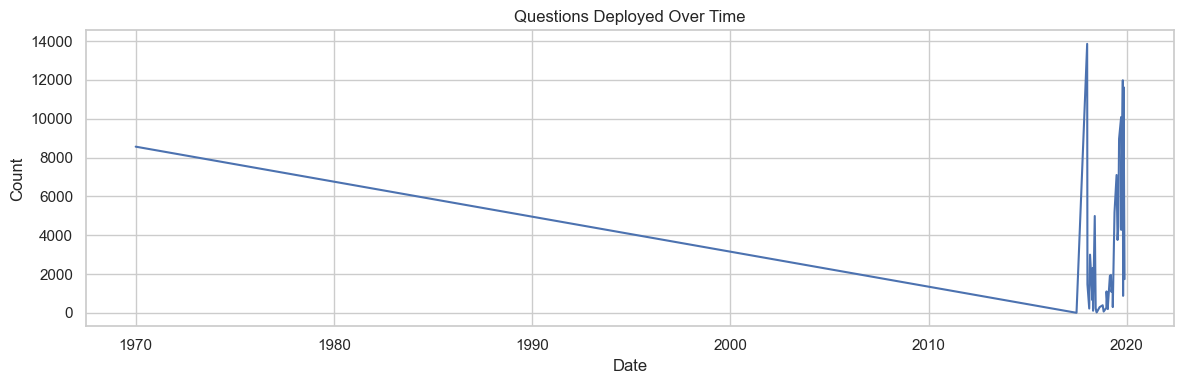

In [40]:
plt.figure(figsize=(12, 4))
merged['deployed_at'].dt.date.value_counts().sort_index().plot()
plt.title("Questions Deployed Over Time")
plt.ylabel("Count")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

**- Key Insights:**

- 1970 to 2005: There’s a steady decline from a peak near 8,000 questions down to almost zero.
- Post-2005: A dramatic reversal occurs with a steep increase, several fluctuations or peaks, reaching close to 14,000 by 2020.
- The downward trend until 2005 may indicate reduced question deployment due to changes in educational strategies, technology, or curriculum focus during those years.
- The surge after 2005 likely reflects a technological advancement—such as digital platform adoption or increased emphasis on interactive learning—and suggests an institutional pivot towards more dynamic content delivery.

#### Tags Analysis

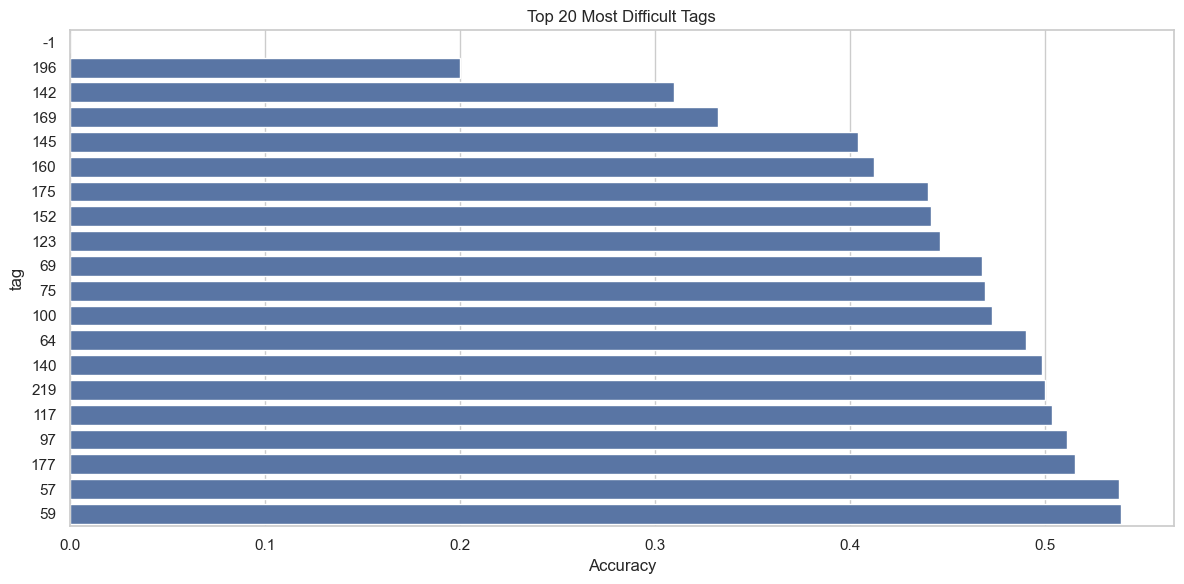

In [41]:
tag_accuracy = []
for tag in tag_counts:
    tag_mask = merged['tags'].apply(lambda x: tag in x if isinstance(x, str) else False)
    if tag_mask.any():
        acc = merged.loc[tag_mask, 'is_correct'].mean()
        tag_accuracy.append((tag, acc, tag_mask.sum()))

tag_acc_df = pd.DataFrame(tag_accuracy, columns=["tag", "accuracy", "count"]).sort_values("accuracy")

# Plot tag difficulty
plt.figure(figsize=(12, 6))
sns.barplot(data=tag_acc_df.head(20), x="accuracy", y="tag")
plt.title("Top 20 Most Difficult Tags")
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()

#### User Interaction Metrics

In [42]:
user_activity = merged.groupby('user_id').agg(
    questions_answered=('question_id', 'count'),
    avg_time=('elapsed_time', 'mean'),
    accuracy=('is_correct', 'mean')
).sort_values("questions_answered", ascending=False)

print("\n--- Top Active Users ---")
user_activity.head()


--- Top Active Users ---


,questions_answered,avg_time,accuracy
user_id,,,
u4517,10923,23589.930056,0.635082
u44037,5970,16673.184422,0.627303
u146988,5872,19959.127554,0.590429
u485101,3815,28081.643512,0.722149
u24698,3610,28406.910526,0.818006


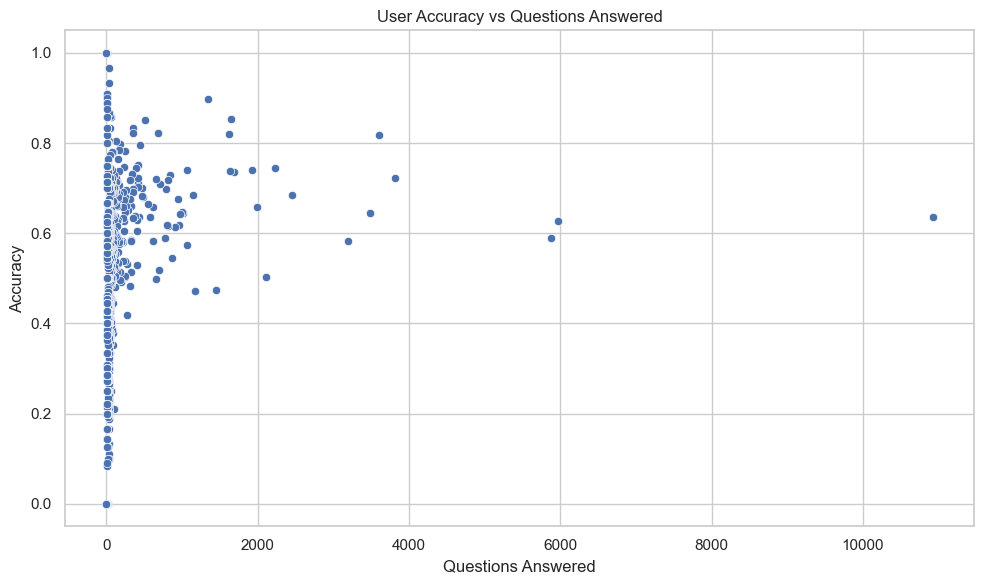

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_activity, x='questions_answered', y='accuracy')
plt.title("User Accuracy vs Questions Answered")
plt.xlabel("Questions Answered")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

#### Checking Imbalance

In [44]:
print("\n--- Top Parts ---")
print(merged['part'].value_counts())


--- Top Parts ---
part
5    50121
2    24973
6    11243
4     9402
3     9139
1     8139
7     4150
Name: count, dtype: int64


The questions span across **7 parts**, with part **5** and **2** being the most dominant. This indicates unequal distribution across the curriculum, which should be considered during model evaluation to avoid favoring overrepresented parts.

In [45]:
print("\n--- Answer Frequency ---")
print(merged['is_correct'].value_counts())


--- Answer Frequency ---
is_correct
True     74623
False    42544
Name: count, dtype: int64


The `is_correct` label shows that **63.7%** of answers are correct, and **36.3%** are incorrect. This is a moderately balanced dataset, indicating that the model can learn both positive and negative signals effectively. Still, I will monitor this balance closely during training.

In [46]:
# 1. Is_correct label distribution
print("=== is_correct distribution ===")
print(merged['is_correct'].value_counts(normalize=True))

=== is_correct distribution ===
is_correct
True     0.636894
False    0.363106
Name: proportion, dtype: float64


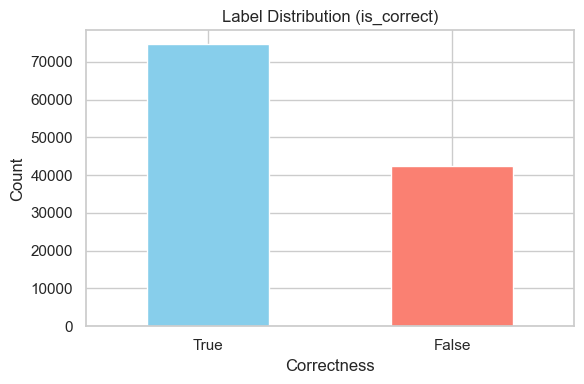

In [47]:
# Visualize class imbalance
plt.figure(figsize=(6,4))
merged['is_correct'].value_counts().plot(kind='bar', color=["skyblue", "salmon"])
plt.title("Label Distribution (is_correct)")
plt.xticks(rotation=0)
plt.xlabel("Correctness")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### Merge tag_difficulty into merged logs & visualize

In [48]:

# Re-split tags
merged['tags'] = merged['tags'].astype(str)
tags_split = merged['tags'].dropna().apply(lambda x: x.split(';'))
all_tags = [tag for sublist in tags_split for tag in sublist]
tag_counts = Counter(all_tags)

# Compute tag difficulty
tag_accuracy = []
for tag in tag_counts:
    mask = merged['tags'].apply(lambda x: tag in x if isinstance(x, str) else False)
    if mask.any():
        acc = merged.loc[mask, 'is_correct'].mean()
        tag_accuracy.append((tag, acc, mask.sum()))

tag_acc_df = pd.DataFrame(tag_accuracy, columns=["tag", "accuracy", "count"]).sort_values("accuracy")


In [49]:
# Explode tags in merged to match with tag_acc_df
merged['tags'] = merged['tags'].astype(str)
merged['tag_list'] = merged['tags'].str.split(';')
exploded = merged.explode('tag_list')

# Merge tag difficulty
exploded = exploded.merge(
    tag_acc_df.rename(columns={"tag": "tag_list", "accuracy": "tag_difficulty"}),
    on="tag_list",
    how="left"
)

# Aggregate tag difficulty per question-user pair
agg = exploded.groupby(['user_id', 'question_id'])['tag_difficulty'].mean().reset_index()

# Merge back to original merged
merged = merged.drop(columns=['tag_list'], errors='ignore')
merged = pd.merge(merged, agg, on=['user_id', 'question_id'], how='left')

# Save updated merged dataset
merged.to_csv("../data/cleaned/merged_cleaned_data.csv", index=False)
print("✅ `tag_difficulty` added and saved to merged_cleaned_data.csv")


✅ `tag_difficulty` added and saved to merged_cleaned_data.csv


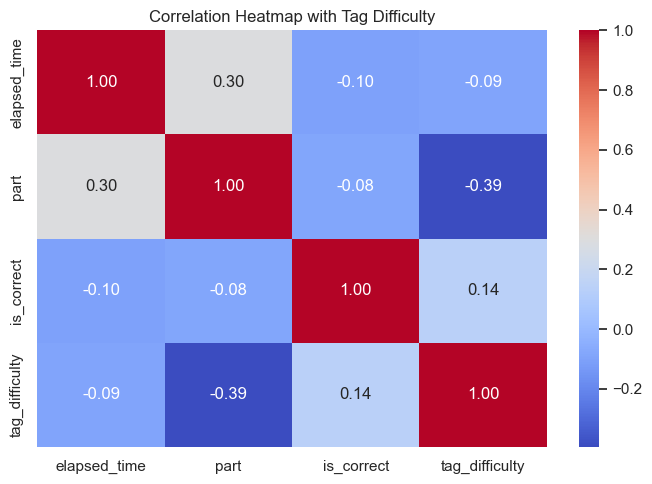

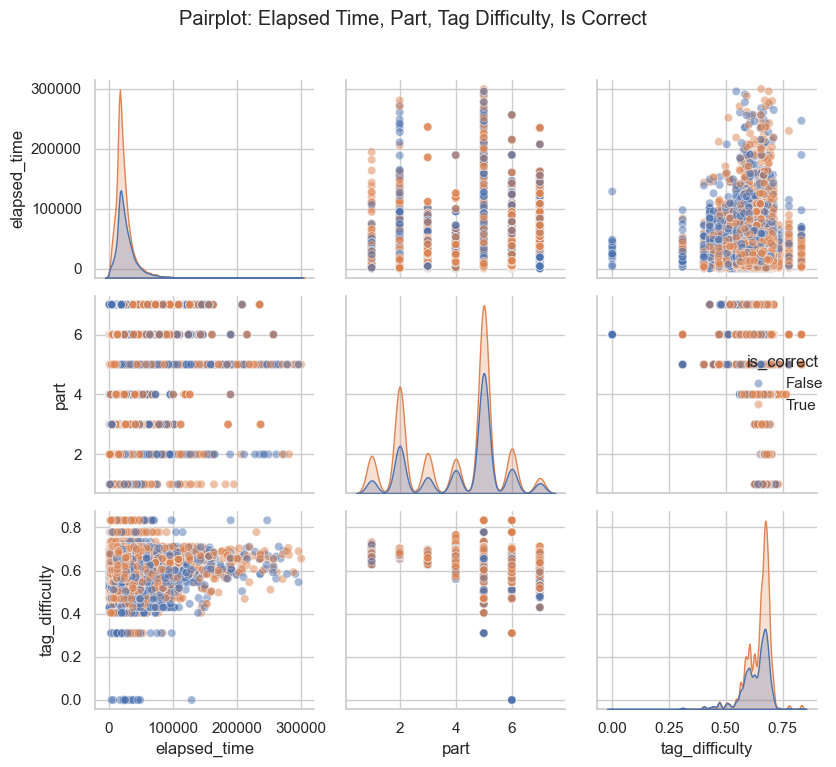

In [50]:
# Updated numeric columns
numeric_cols = ['elapsed_time', 'part', 'is_correct', 'tag_difficulty']

# Correlation Heatmap (with tag_difficulty)
plt.figure(figsize=(7, 5))
sns.heatmap(merged[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap with Tag Difficulty")
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(merged[numeric_cols], hue="is_correct", plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot: Elapsed Time, Part, Tag Difficulty, Is Correct", y=1.02)
plt.tight_layout()
plt.show()

### 2. Lectures data

#### Load Cleaned Lectures

In [51]:
lectures = pd.read_csv("../data/cleaned/cleaned_lectures.csv")

#### Basic Distributions

In [52]:
# Unique counts
print("\nUnique Counts per Column:")
lectures.nunique()


Unique Counts per Column:


lecture_id       1021
part                8
tags              259
video_length      283
deployed_at       568
video_minutes     283
dtype: int64

#### Part Distribution

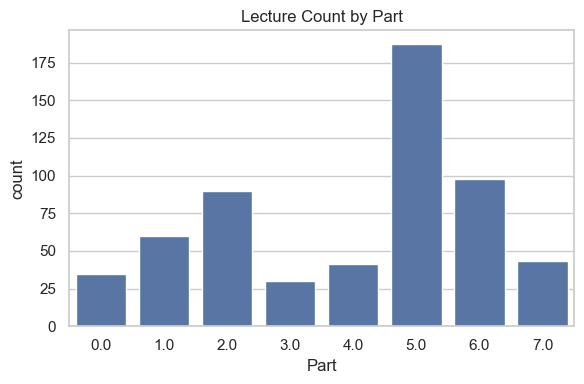

In [53]:
plt.figure(figsize=(6, 4))
sns.countplot(data=lectures, x="part")
plt.title("Lecture Count by Part")
plt.xlabel("Part")
plt.tight_layout()
plt.show()

#### Video Length Distribution

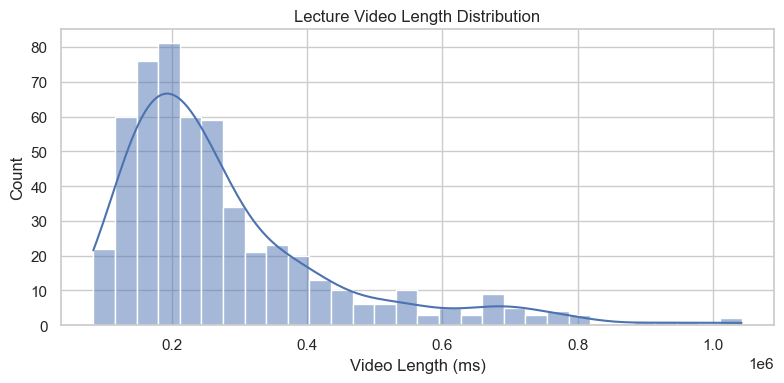

In [54]:
plt.figure(figsize=(8, 4))
sns.histplot(lectures["video_length"].dropna(), bins=30, kde=True)
plt.title("Lecture Video Length Distribution")
plt.xlabel("Video Length (ms)")
plt.tight_layout()
plt.show()

Handle imbalance later, after building baseline models — this helps you:

 Why Delay Handling Imbalance?

| Step               | Reason                                                                                                  |
| ------------------ | ------------------------------------------------------------------------------------------------------- |
| 1️⃣ EDA            | Understand structure, bias, user/question distributions.                                                |
| 2️⃣ Baseline model | See how imbalance affects performance **naturally**.                                                    |
| 3️⃣ Then handle it | Apply weighting/resampling **if needed** based on evaluation metrics (e.g., if Precision\@K is skewed). |


### ✅ Focus Now:

* Stick with `merged_cleaned_data.csv` (user–question)
* Finish **EDA** & build **user–question interaction matrix**

---

Want to now build the interaction matrix (`user_id × question_id` with `is_correct` or counts)?
Or would you prefer to finish advanced EDA (correlation, tag-level difficulty)?

**a.** Build the interaction matrix
**b.** Advanced EDA like correlation or tag-level difficulty

**✅ Recommended: `a. Yes, merge tag difficulty into questions.csv`**

---

### Why?

Merging it into `questions.csv` means:

* You **enrich the dataset** — each question now carries tag difficulty info.
* Easier access during modeling (e.g., for feature engineering in content-based models).
* Helps later for **hybrid models**, where both content features (like tag difficulty) and collaborative signals are used.

---

### How?

Since `questions["tags"]` is a **multi-tag field**, we:

1. **Explode tags** into multiple rows
2. Merge with `tag_difficulty_df` on each tag
3. Aggregate (e.g., mean) back per question

Would you like me to code this?
